In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [ ]:
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/5thcopy.csv')
df

,Date,SN
0,2020-01-01,6.20
1,2020-02-01,0.20
2,2020-03-01,1.50
3,2020-04-01,5.20
4,2020-05-01,0.20
...,...,...
127,2030-09-01,9.85
128,2030-10-01,9.27
129,2030-11-01,9.06
130,2030-12-01,9.20


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['SN']=pd.to_numeric(df['SN'], errors= 'coerce')
df

,Date,SN
0,2020-01-01,6.20
1,2020-02-01,0.20
2,2020-03-01,1.50
3,2020-04-01,5.20
4,2020-05-01,0.20
...,...,...
127,2030-09-01,9.85
128,2030-10-01,9.27
129,2030-11-01,9.06
130,2030-12-01,9.20


In [ ]:
from scipy.special import erf
results=[]
def skewed_gauss(x, A, mu, sigma, alpha):
        t = (x - mu) / sigma
        return A * np.exp(-0.5 * t**2) * (1 + erf(alpha * t / np.sqrt(2)))

In [ ]:
x = (df['Date'] - df['Date'].min()).dt.days.values
y = df['SN'].values


In [ ]:
p0 = [max(y), np.median(x), np.std(x), 2]
bounds = ([0, min(x), 0, -10], [np.inf, max(x), np.inf, 10])


Cycle 25 Fitted Parameters:
A = 101.28, mu = 1061.98, sigma = 1308.16, alpha = 2.21


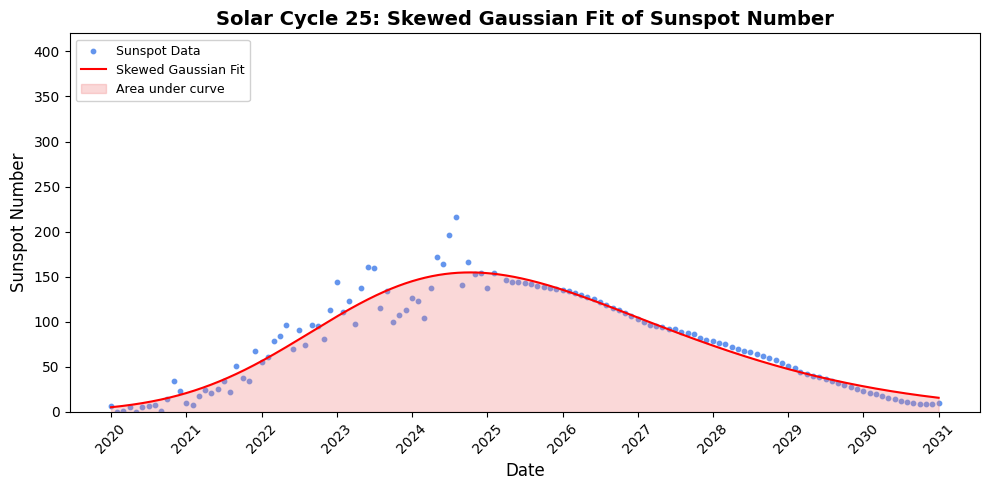

In [ ]:
try:
        params, _ = curve_fit(skewed_gauss, x, y, p0=p0, bounds=bounds, maxfev=10000)
        A, mu, sigma, alpha = params

        x_fit = np.linspace(min(x), max(x), 10000)
        y_fit = skewed_gauss(x_fit, A, mu, sigma, alpha)
        dx = x_fit[1] - x_fit[0]

        cum_area = np.cumsum(y_fit) * dx
        total_area = cum_area[-1]
        cum_area_norm = cum_area / total_area

        skewness = skew(y)
        kurt = kurtosis(y)

        def find_bounds(cum_area, x_fit, level):
            lower_idx = np.argmax(cum_area >= (1 - level) / 2)
            upper_idx = np.argmax(cum_area >= 1 - (1 - level) / 2)
            return x_fit[lower_idx], x_fit[upper_idx]

        x_lower_1sigma, x_upper_1sigma = find_bounds(cum_area_norm, x_fit, 0.6827)
        x_lower_2sigma, x_upper_2sigma = find_bounds(cum_area_norm, x_fit, 0.9545)

        start_ref = df['Date'].min()
        mu_date = start_ref + pd.to_timedelta(mu, unit='D')
        date_lower_1 = start_ref + pd.to_timedelta(x_lower_1sigma, unit='D')
        date_upper_1 = start_ref + pd.to_timedelta(x_upper_1sigma, unit='D')
        date_lower_2 = start_ref + pd.to_timedelta(x_lower_2sigma, unit='D')
        date_upper_2 = start_ref + pd.to_timedelta(x_upper_2sigma, unit='D')

        width_1sigma = x_upper_1sigma - x_lower_1sigma
        width_2sigma = x_upper_2sigma - x_lower_2sigma
        width_1sigma_years = width_1sigma / 365.25
        width_2sigma_years = width_2sigma / 365.25


        area_simpson = simpson(y_fit, x=x_fit)

        print(f"\nCycle 25 Fitted Parameters:")
        print(f"A = {A:.2f}, mu = {mu:.2f}, sigma = {sigma:.2f}, alpha = {alpha:.2f}")


        results.append({
        'Skewness (Data)': skewness,
        'Excess Kurtosis (Data)': kurt,
        'Total Area (Simpson)': area_simpson/ 365.25,
        '1σ Width (years)': width_1sigma_years,
        '2σ Width (years)': width_2sigma_years,
        })


        plt.figure(figsize=(10, 5))
        plt.scatter(df['Date'], y, label='Sunspot Data', color='cornflowerblue', s=10)
        x_dates = start_ref + pd.to_timedelta(x_fit, unit='D')
        plt.plot(x_dates, y_fit, label='Skewed Gaussian Fit', color='red')
        plt.fill_between(x_dates, y_fit, color='lightcoral', alpha=0.3, label='Area under curve')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Sunspot Number", fontsize=12)
        plt.ylim(0, 420)
        plt.title(f"Solar Cycle 25: Skewed Gaussian Fit of Sunspot Number", fontsize=14, weight='bold')
        plt.legend(loc='upper left', fontsize=9, frameon=True, framealpha=0.9)
        plt.tight_layout()
        plt.savefig(("cycle25_fit_enhanced.png"), dpi=300, bbox_inches='tight')
        plt.show()

except Exception as e:
        print(f"\nCycle 25 Error: {e}")



In [ ]:
df_results = pd.DataFrame(results)
df_results

,Skewness (Data),Excess Kurtosis (Data),Total Area (Simpson),1σ Width (years),2σ Width (years)
0,0.175815,-0.991461,884.661261,4.628451,8.726616
